# Detecting Outliers from Hourly Load

This post was originally going to focus on modeling hourly, regional electricity load data until I noticed that some of the series that I was importing from EIA appeared to be contaminated with outliers and missing data. I started scrubbing the data and I realized that it was actually kind of an intersting problem so I decided to turn the exercise into its own article. I know that this might not seem like the sexiest topic BUT I've spiced it up by using an incorporating an unsupervised machine learning method called an Isolation Forrest.

### Installing Packaes

Let's start by declaring all of the package and script dependencies. Note that EIAPI is a script that we are importating based on my first [jupyter article]( https://nbviewer.jupyter.org/github/johnmrudolph/jupyter_blog/blob/master/working_with_apis.ipynb) which shows how to pull EIA data using the EIA API. The EIAPI script can be found on my github [here](https://github.com/johnmrudolph/jupyter_blog/blob/master/scripts/eiapi.py).

In [1]:
# optional imports to run local and to set pandas display format
import sys
sys.path.insert(0, './scripts/')
# https://github.com/johnmrudolph/jupyter_blog/blob/master/scripts/eiapi.py
import eiapi as epi

# pandas and numpy will be used for data manipulation
import pandas as pd
import numpy as np
# sklearn has the Isolation Forrest model that we will use for outlier detection
from sklearn.ensemble import IsolationForest
# matplotlib will help us do some graphing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# we will need to do some datetime conversion
from datetime import datetime

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Creating the Datasets

We're going to look at hourly load data from 6 different WECC Balancing Authorities. Each Balancing Authority serves a geographic region which will have its own unique load profile. Hourly load can fluctuate significantly depending on the day of the week, the time of day (peak or off-peak hours) and prevailing weather conditions.

To pull the hourly load data for each of the Balancing Authorities we can use the GetSeries class from the EIAPI script. This will return a pandas dataframe of dates and values for each series that we request. To use the GetSeries class a few parameters need to be specified. Required inputs are an API key and a series_id. I also specify the optional paramters, start date, end date and the frequency, so that we can query a specified date range. If you are dealing with hourly time series data then your datasets can get pretty large if you are not careful.

In [2]:
# can be obtained from EIA here: http://www.eia.gov/opendata/register.php
api_key = 'YOUR API KEY HERE'
# start and end dates for beginning and end of time series
# pulling data from Dec 2016 - Jan 2016
# must be in yyyy-mm-dd hh:mm:ss format if pulling hourly data
start = '2015-12-01 01:00:00'
end = '2016-01-31 23:00:00'
# must specify that frequency is hourly 'H' for datetime conversion
freq = 'H'

# create list of series_id used for dictionary keys
# going to pull 6 balancing authorities
# full list of available series is here: http://www.eia.gov/opendata/qb.php?category=2122628
keys = ['EBA.BPAT-ALL.D.H', 'EBA.PACE-ALL.D.H', 'EBA.PACW-ALL.D.H', 
        'EBA.PGE-ALL.D.H', 'EBA.PSEI-ALL.D.H', 'EBA.SCL-ALL.D.H']

# create dict of GetSeriesRange objects from series list
series_dict = {key: epi.GetSeries(api_key=api_key, series_id=key, 
                                    start=start, end=end, freq=freq) for key in keys}

### Inspecting the API Data

The GetSeries class stores the json and subsets of the json to make it easier to get at some of the underlying data. I'm familiar with the format of the JSON returned from the EIA API so I know that I can pull out the ull name of the series by keying off the 'name' key which is nested several layers deep in the JSON. BHere is some additional detail on [EIA JSON formatting](http://www.eia.gov/opendata/commands.php). 

Let's print the full name of each of the 6 series that we queried. 

In [3]:
# loop over dictionary and print out full name of each series
for key in series_dict:
    print('{}: {}'.format(series_dict[key].data.series[0]['name'],key))

Demand for Bonneville Power Administration (BPAT), Hourly: EBA.BPAT-ALL.D.H
Demand for PacifiCorp East (PACE), Hourly: EBA.PACE-ALL.D.H
Demand for PacifiCorp West (PACW), Hourly: EBA.PACW-ALL.D.H
Demand for Portland General Electric Company (PGE), Hourly: EBA.PGE-ALL.D.H
Demand for Puget Sound Energy, Inc. (PSEI), Hourly: EBA.PSEI-ALL.D.H
Demand for Seattle City Light (SCL), Hourly: EBA.SCL-ALL.D.H


OK so now we can see that we are pulling hourly load data for 6 different WECC Balancing Authorities: 
1. PacifiCorp East
2. PacifiCorp West
3. Bonneville Power Administration (BPA)
4. Seattle City Light
5. Puget Sound Energy
6. Potland General Electric

To make the data easier to work with I'm going to merge all the series into a single dataframe and I'm going to pickle the merged dataframe so that this data is available without having to cal the EIA API again. If you want to work with the data without having to do an API call then the pkl file can be found [here](https://github.com/johnmrudolph/jupyter_blog/blob/master/data/nw_load_df.pkl).

In [4]:
# merge dataframes from series_dict in a loop
concat_df = pd.concat([series_dict[key].data.df for key in series_dict], axis=1, sort=False)
# output merged dataframe as a pkl file
concat_df.to_pickle('data/nw_load_df.pkl')
# to read pkl back into a pandas df
# concat_df = pd.read_pickle('data/new_load_df.pkl')

### Descriptive Statistics

We are reasonably confident that we are pulling something from EIA so lets try to take a look at the hourly load for each series. We can do this by looping over the dataframe and using the list of keys list that we defined earlier. Each key will correspond with the underlying data values returned from the EIA API, which should be hourly load in MW. Pandas has built in functions to give us the mean, median, min and max for each variable in a dataframe.

In [5]:
# print out descriptive statistics for each series
for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7059.477471418964 ' median :'7109.0 ' min :'5006 ' max :'9365
EBA.PACE-ALL.D.H '	
 mean :'-30996.634443541836 ' median :'5563.0 ' min :'-31990166.0 ' max :'8521.0
EBA.PACW-ALL.D.H '	
 mean :'4948.43926056338 ' median :'2710.0 ' min :'-6785.0 ' max :'2530003.0
EBA.PGE-ALL.D.H '	
 mean :'2579.9219905850705 ' median :'2646.0 ' min :'1730 ' max :'3472
EBA.PSEI-ALL.D.H '	
 mean :'3944.688995215311 ' median :'4018.0 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1282.2589105581708 ' median :'1324.0 ' min :'868 ' max :'1654


Based on the descriptive stats output above we can make a few observations:
1. The median seems to give us the clearest picture of load for each series
2. PacifiCorp East (EBA.PACE-ALL.D.H) and PacifiCorp West (EBA.PACW-ALL.D.H) appear to have some wonky values

Negative values don't really make a whole lot of sense here. It shouldn't be possible for a balancing authority to have negative load so it is safe to assume that we can remove these from the dataset.

### Filtering out Negative Values

Let's loop through the dataframe and replace any negative values with NAs. Then we can use pandas to fill in the NAs using an interpolation.

In [6]:
for key in keys:
    concat_df[concat_df[key] < 0] = np.nan

# keeping it simple by using a linear interpolation
concat_df = concat_df.dropna()

Let's output the descriptive statistics again to see if our negative values have been replaced with something more reasonable. This will come through in the min and the average.

In [7]:
for key in keys:
    print(key,
          "'\t\n mean :'{}".format(concat_df[key].mean()),
          "' median :'{}".format(concat_df[key].median()),
          "' min :'{}".format(concat_df[key].min()),
          "' max :'{}".format(concat_df[key].max())
          )

EBA.BPAT-ALL.D.H '	
 mean :'7019.96764091858 ' median :'7066.0 ' min :'5006.0 ' max :'9075.0
EBA.PACE-ALL.D.H '	
 mean :'5518.33611691023 ' median :'5555.5 ' min :'4386.0 ' max :'8521.0
EBA.PACW-ALL.D.H '	
 mean :'2757.7546972860127 ' median :'2708.0 ' min :'1763.0 ' max :'68178.0
EBA.PGE-ALL.D.H '	
 mean :'2581.0835073068893 ' median :'2656.0 ' min :'1751.0 ' max :'3445.0
EBA.PSEI-ALL.D.H '	
 mean :'3897.001043841336 ' median :'3974.5 ' min :'2292.0 ' max :'5088.0
EBA.SCL-ALL.D.H '	
 mean :'1280.4926931106472 ' median :'1327.5 ' min :'868.0 ' max :'1654.0


As expected the negative value problem has been corrected BUT PacifiCorp East and West have MAX values that are WAY to big and it is clearly throwing off the mean. At this point, I'm a bit stuck at how to proceed. I don't have a whole lot of confidence in this datset. I know that there are at least 2 values that are clearly incorrect BUT I don'thave a good feel about how much contamination there is in this dataset.

I did some research on outlier detection and I found this helpful article from [sci-kit learn](http://scikit-learn.org/stable/modules/outlier_detection.html) from which compares some of the different outlier detection methods. The Isolation Forrest method seemed like a good fit because of it's well rounded performance compared to the other methods and its computational efficiency. Another benefit is that we can use the output of the IsolationForrest to easily graph and visually inspect each individual observation to specify our outlier criteria.

### Predicting outliers with an Isolation Forrest

I have a pretty solid understanding of most supervised machine learning methods however I will freely admit that I am not an expert at unsupervised machine learning. The reading material and examples provided by sklearn is a little sparse but I was able to get started by looking at this [example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py). More detail documentation for the Isolation Forrest can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

Let's define a class to fit the IsolationForrest and return predictions.

In [8]:
class PredictOutliers(object):
    '''
    Fits an IsolationForrest model and returns the input dataframe with
    outlier prediction and outlier prediction decision function
    '''
    
    def __init__(self, input_data, label, col1, col2, cont, rand):
        '''
        :param input_data: a dataframe that contains the values and features to be fit
        :param label: name of series being fitted
        :param col1: the values which will be fitted by Isolation Forrest
        :param col2: the feature which will be fitted by Isolation Forrest
        :cont: the estimated contamination in the dataset between 0-1
        :rand: a random seed value to use for estimation
        '''
        # subset input dataframe based on col1 (values) and col2 (feature)
        self.training_data = pd.DataFrame(input_data.loc[:,[col1, col2]])
        self.clf = self.fit_clf(cont, rand, self.training_data)
        # label and index will be used for the outlier prediction dataframe
        self.label = label
        self.index = input_data.index.values
        # fit Isolation Forrest and merge prediction with training dataframes
        self.pred_data = pd.concat([self.training_data, self.create_predictions()], axis=1)
    
    def fit_clf(self, cont, rand, training_data):
        '''
        Defines the Isolation forrest - contamination rate and random_state are required
        :cont: the estimated contamination in the dataset between 0-1
        :rand: a random seed value to use for estimation
        '''
        clf = IsolationForest(contamination=cont, random_state=rand, behaviour="new")
        return clf.fit(self.training_data.values)
    
    def create_predictions(self):
        '''
        fits the clf to input dataframe and returns a dataframe with the outlier prediction and
        outlier decision function
        '''
        # predicts whether observation is an outlier - returns a boolean
        opred = self.clf.predict(self.training_data.values)
        # returns the decision function used for outlier prediction
        # will be a decimal value - the more negative the more likely an outlier
        dfunc = self.clf.decision_function(self.training_data.values)
        # set dataframe labels for prediction and decision function
        l1 = '{}{}'.format(self.label, '_opred')
        l2 = '{}{}'.format(self.label, '_dfunc')
        # return a dataframe of prediction and decision function
        return pd.DataFrame(np.column_stack((opred, dfunc)), index=self.index, columns=[l1, l2])

Now let's put the PredictOutliers class to work. We are going to supply a contamination of 0.01 (1%), this is just an educated guess based on taking a look at the data. This contamination rate determines the number of outliers predicted by the Isolation Forrest. In this case we are assuming that about 1% of the observations will be outliers. Depending on the dataset it could be more or less than this and it could take a little trial and error to figure this value out.

In [9]:
# Need to to modify our dataframe a bit before we can run it through the PredictOutliers class
# Interpolate missing values
concat_df = concat_df.interpolate(method='linear')
# convert hour to datetime format
concat_df.loc[:,'HOUR'] = pd.to_datetime(concat_df.index).hour
# Create a dictionary of predictions for each series
pred_dict = {key: PredictOutliers(concat_df, key, 'HOUR', key, .01, 1234) for key in keys}

In the code above we created predictions for each of the 6 series and stored the results as dictionary of dataframes. Let's examine the IsolationForrest predictions. We'll start by looking at the decision function, which is a measure of normaility produced for each observation fitted by IsolationForrest. The decision function will be a small decimal value, the more negative the value the less normal the observation.

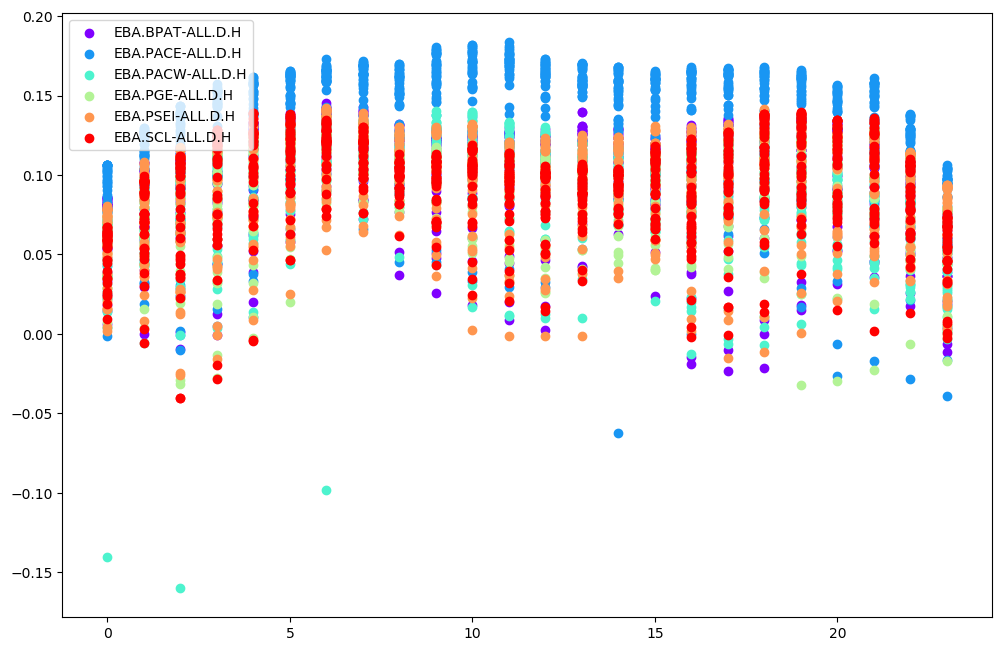

In [10]:
# Plot the decision function for each series
fig = plt.figure(figsize=(12, 8), dpi=100)
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))
# loop through pred_dict and add each series to a scatter plot
for key, color in zip(keys, colors):
    pred_data = pred_dict[key].pred_data
    plt.scatter(pred_data['HOUR'].values, pred_data['{}{}'.format(key, '_dfunc')].values, 
                color=color, label=key)
legend = plt.legend(loc='upper left')
plt.show()

### Interpreting the Decision Function Plot

The scatter plot above is colorful but what is it showing us? Remember that more negative decision function values are more likely to be outliers. With that in mind, it looks like the largest potential outliers are from EBA.PACW-ALL.D.H (PacifiCorp West).

Now let's have a look at the outliers predicted by the Isolation Forrest. We can look at the "opred" column to do this. An "opred" value of -1 indicates the the Isolation Forrest predicted the observation as an outlier. For each predicted outlier we will also print out the observed hourly load and the decision function value to help us determine if the prediction is correct.

In [11]:
# Output all observations that are predicted to be outliers by Isolation Forrest
for key in keys:
    pred_df = pred_dict[key].pred_data
    print(key + ': \n',
          # _opred == -1 is classified as outlier - also output load and decision function
          pred_df[pred_df[key + '_opred'] == -1][[key,key + '_dfunc']].sort_values(by = key + '_dfunc')
          )

EBA.BPAT-ALL.D.H: 
                      EBA.BPAT-ALL.D.H  EBA.BPAT-ALL.D.H_dfunc
2015-12-31 17:00:00          9075.000                  -0.023
2015-12-31 18:00:00          8991.000                  -0.022
2016-01-04 16:00:00          8990.000                  -0.019
2015-12-31 16:00:00          8945.000                  -0.015
2016-01-22 23:00:00          6079.000                  -0.011
2016-01-04 17:00:00          8941.000                  -0.010
2015-12-01 02:00:00          8904.000                  -0.009
2016-01-04 23:00:00          8096.000                  -0.006
2015-12-01 03:00:00          8855.000                  -0.001
2016-01-04 18:00:00          8809.000                  -0.000
EBA.PACE-ALL.D.H: 
                      EBA.PACE-ALL.D.H  EBA.PACE-ALL.D.H_dfunc
2016-01-05 14:00:00          8521.000                  -0.062
2015-12-19 23:00:00          4509.000                  -0.039
2015-12-19 22:00:00          4505.000                  -0.028
2015-12-01 20:00:00          6

### Filtering the outlier values

We can see from the output above that most of the predicted outliers actually look somewhat reasonable. For example the largest predicted outlier for EBA.SCL-ALL.D.H (Seattle City Light) has a decision function value of -0.031 and an observed load of 1653 MW which is inline with its median load of 1322 MW. However we clearly can see the outliers in EBA.PACW-ALL.D.H (PacifiCorp West):

<table>
  <tr>
    <th>Date</th>
    <th>EBA.PACW-ALL.D.H</th> 
    <th>EBA.PACW-ALL.D.H_dfunc</th>
  </tr>
  <tr>
    <td>2016-01-11 00:00:00 </td>
    <td>2530003</td> 
    <td>-0.176</td>
  </tr>
  <tr>
    <td>2015-12-09 02:00:00</td>
    <td>68178</td> 
    <td>-0.138</td>
  </tr>
</table>

It looks like the best way to filter out and correct these outliers is to use the decision function value for each series to remove any obvious outliers. Let's code up a quick function to help us do this.

In [12]:
# create a function for filtering our dataframes based on decision function values
def dfunc_filter(filter_list, pred_dict):
    '''
    Filters a dataframe in a dictionary based on supplied decision function value and
    will remove observed load value based on decision function filter criteria and replace
    with linear interpolated value
    :filter list : a list of tuples - each tuple has the series (dictionary key) and decision function filter value
    :pred_dict : dictionary of dataframes
    '''
    for tup in filter_list:
        pred_data = pred_dict[tup[0]].pred_data
        pred_data.loc[pred_data[tup[0] + '_dfunc'] <= tup[1], tup[0]] = np.nan
        pred_data.loc[:,tup[0]] = pred_data.loc[:,tup[0]].interpolate(method='linear')
        print(pred_data[pred_data[tup[0] + '_dfunc'] <= 
                  tup[1]][[tup[0],tup[0] + '_dfunc']].sort_values(by = tup[0] + '_dfunc'))

We can apply the dfunc_filter function to EBA.PACW-ALL.D.H as follows using -0.10 as our decision function threshold.

In [13]:
# call function to apply filters
dfunc_filter([('EBA.PACW-ALL.D.H', -0.05), ('EBA.PACE-ALL.D.H', -0.05)], pred_dict)

                     EBA.PACW-ALL.D.H  EBA.PACW-ALL.D.H_dfunc
2015-12-09 02:00:00          2666.000                  -0.160
2016-01-06 00:00:00          3026.500                  -0.140
2016-01-12 06:00:00          2802.000                  -0.098
                     EBA.PACE-ALL.D.H  EBA.PACE-ALL.D.H_dfunc
2016-01-05 14:00:00          5850.000                  -0.062


### Plotting the filtered series

This should have replaced the large outlier PacifiCorp hourly load values with linear interpolated values. We can check this by graphing each series to see if the hourly load values look reasonable.

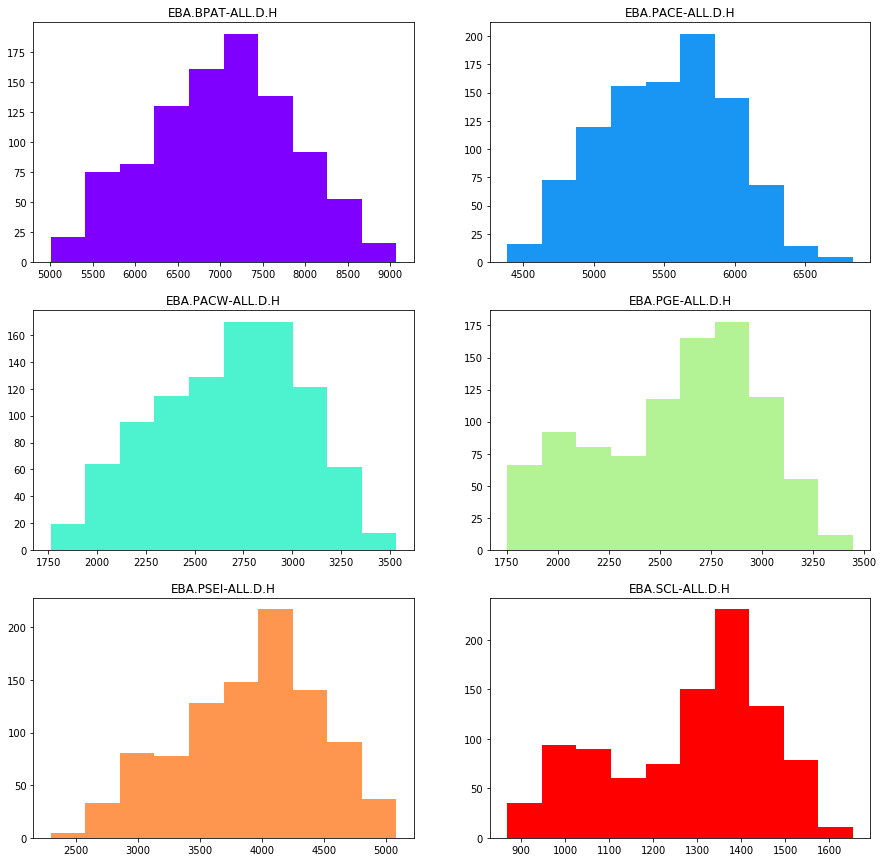

In [14]:
# create subplot for the 6 BAs
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

# create a list for each plot
hist_list = [ax0, ax1, ax2, ax3, ax4, ax5]
# create list of colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(keys)))

for key, hist_item, color in zip(keys, hist_list, colors):
    hist_item.hist(pred_dict[key].pred_data.loc[:,key].values, color=color)
    hist_item.set_title(key)
    
plt.show()

Each series has been plotted above using a historgram. There do not appear to be any clear outliers based on the individual distributions.